# Домашнее задание 8


**Реализовать синтезирование лиц из LFW с помощью DCGAN**
**Библиотеки: [Python, Tensorflow]**

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

## Подключение библиотек

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка и подготовка датасета LFW

In [3]:
if 1:
  train_ds, info_ds = tfds.load(
      'lfw',
      as_supervised=True,
      with_info=True,
      split='train'
  )

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteL3PUBJ/lfw-train.tfrecord



Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [4]:
train_ds

<DatasetV1Adapter shapes: ((), (250, 250, 3)), types: (tf.string, tf.uint8)>

In [5]:
info_ds

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

## Визуализация датасета LFW

In [6]:
PIC_TO_SHOW = 12

In [17]:
def plot_images(ds, img_cnt):
    samples = [[x[0], x[1]] for x in iter(ds.take(img_cnt))]

    fig = plt.figure(figsize=(20,20))

    for i in range(len(samples)):
        ax = fig.add_subplot(9,9,i+1)
        ax.set_title(samples[i][0].numpy().decode('UTF-8'))
        ax.imshow(samples[i][1])
        plt.xticks([])
        plt.yticks([])

    plt.show()

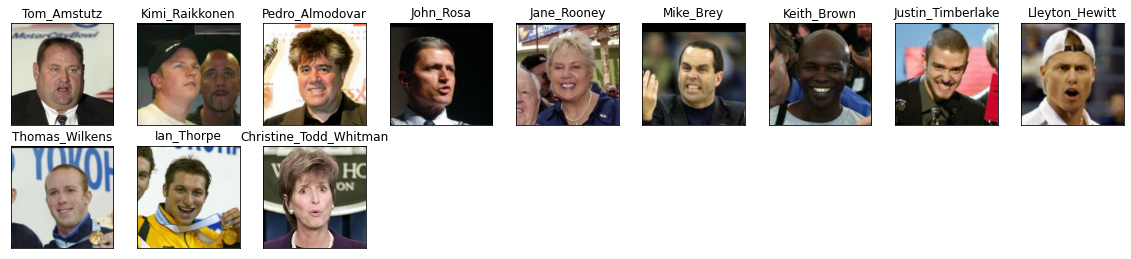

In [18]:
plot_images(train_ds, PIC_TO_SHOW)

## Создание Генератора и Дискриминатора Deep Convolutional GAN (DCGAN)¶

In [19]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*7*7, activation='relu'),
    tf.keras.layers.Reshape((7, 7, 256)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),   
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),        
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

## Подготовка пайплайна данных и оптимизатора

In [20]:
INPUT_DIM = 100
NUM_EPOCHS = 15
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

In [21]:
def prepare(label, img):
    img = tf.image.resize(img, [224, 224])
    return label, (tf.cast(img, tf.float32)- 127.5) / 127.5

In [22]:
train_ds = train_ds.shuffle(buffer_size=11000)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(prepare)

In [23]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Отобразим генератор графически

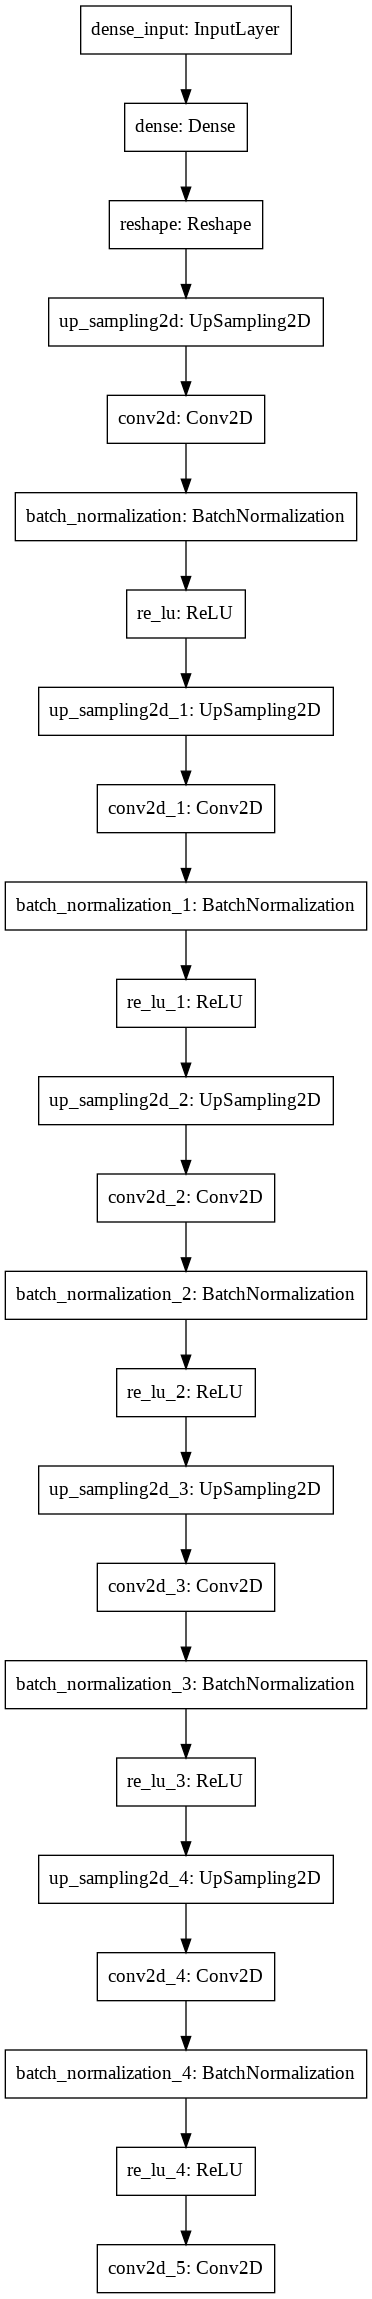

In [30]:
tf.keras.utils.plot_model(generator)

## Отобразим дискриминатор графически

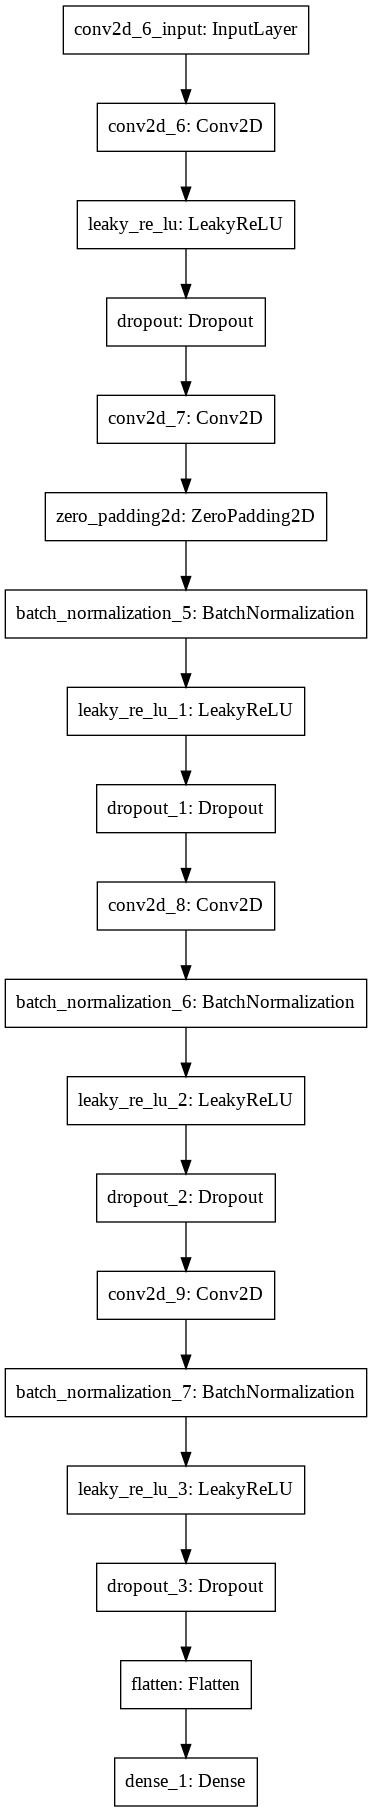

In [31]:
tf.keras.utils.plot_model(discriminator)

## Обучение DCGAN

In [25]:
def plot_images(samples):
    fig = plt.figure(figsize=(20, 20))
    num = samples.shape[0]
    for i in range(num):
        ax = fig.add_subplot(9,9,i+1)
        img = (samples[i, ...] * 127.5) + 127.5
        img = (tf.cast(img, tf.int16))
        ax.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.show()

[Step  0] D Loss: 1.0583; G Loss: 0.5752


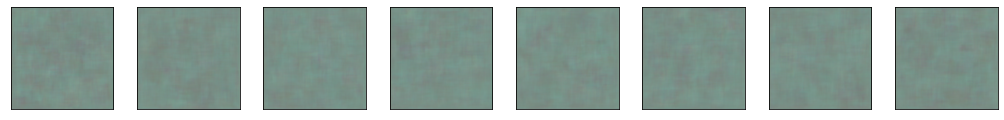

[Step 1000] D Loss: 1.2798; G Loss: 34.9396


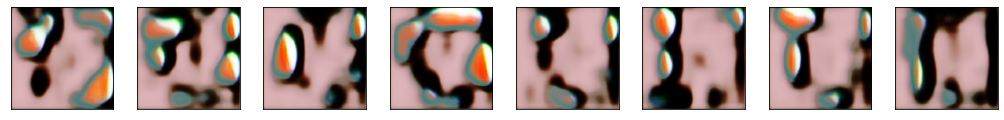

[Step 2000] D Loss: 1.8080; G Loss: 46.8054


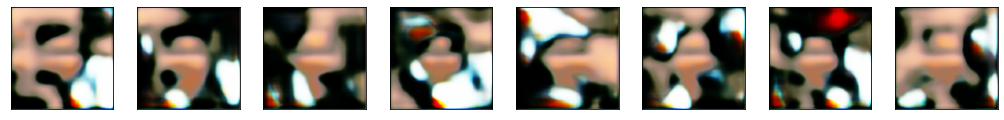

[Step 3000] D Loss: 2.4151; G Loss: 14.3837


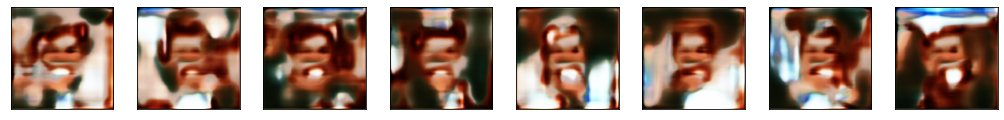

[Step 4000] D Loss: 0.1014; G Loss: 24.0775


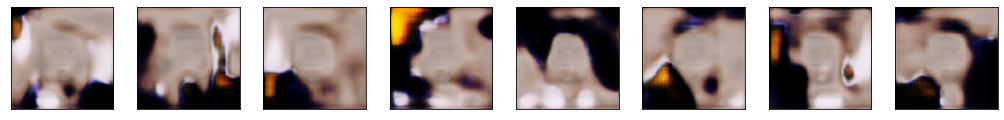

[Step 5000] D Loss: 3.2941; G Loss: 45.2991


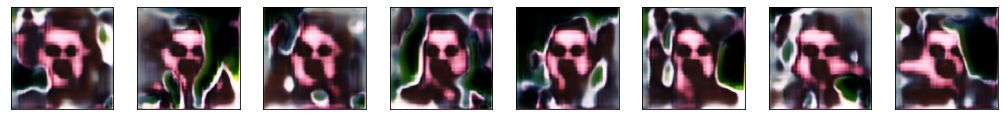

[Step 6000] D Loss: 6.8299; G Loss: 24.1323


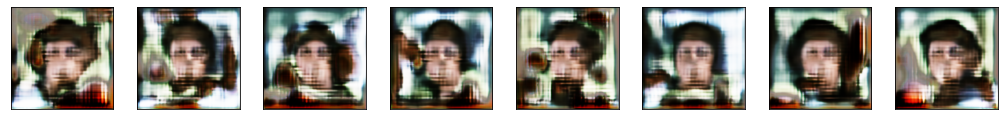

[Step 7000] D Loss: 0.9085; G Loss: 4.0622


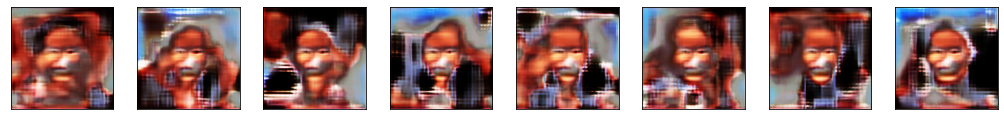

[Step 8000] D Loss: 1.0478; G Loss: 29.6455


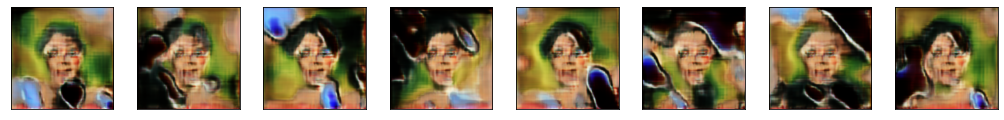

[Step 9000] D Loss: 0.8712; G Loss: 20.8130


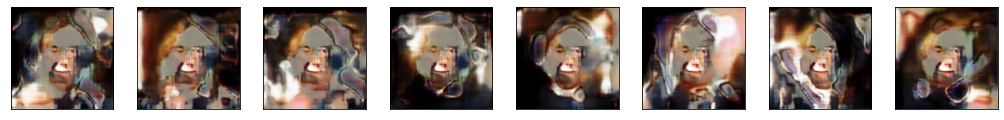

[Step 10000] D Loss: 0.9462; G Loss: 35.8568


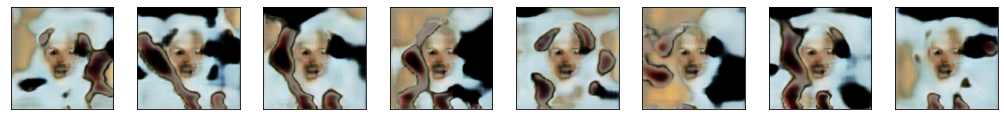

[Step 11000] D Loss: 0.3644; G Loss: 14.2421


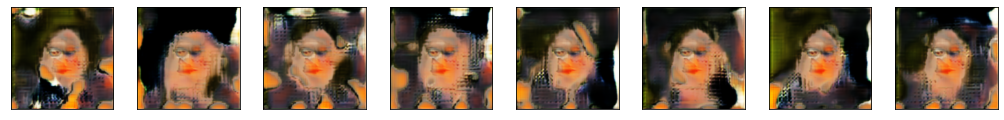

[Step 12000] D Loss: 1.1192; G Loss: 32.3309


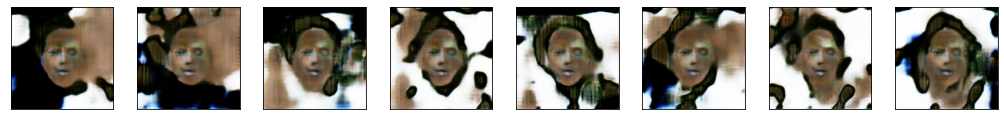

CPU times: user 26min 2s, sys: 2min 27s, total: 28min 30s
Wall time: 48min 11s


In [26]:
%%time

for step, (_, true_images) in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 1000 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_images(syntetic_images)

## Тестирование свёрточного генератора

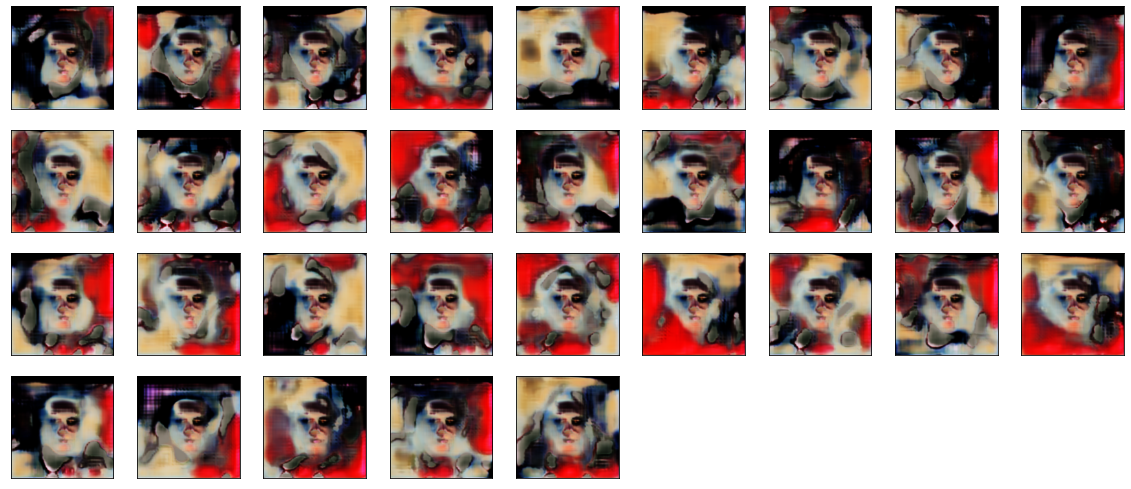

In [27]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_images(syntetic_images)

## Интерполяция в латентном пространстве

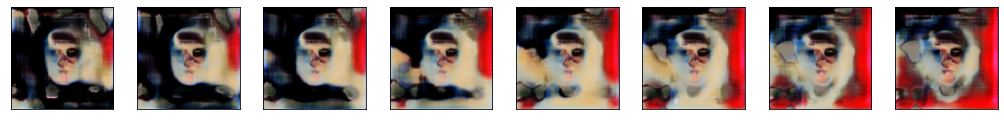

In [28]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_images(syntetic_images)

**Выводы:** 
- на синтезированных изображениях довольно четко проявляется лицо человека;
- для улучшения качества можно поиграться с моделью Генератора и Дискриминатора DCGAN, а также увеличить число эпох;
- задача решена. Полученные результаты верны.